In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

ds = xr.open_dataset('../data/salt/NO_TS_MO_UFSDeutscheBucht.nc')
df = ds["PSAL"].to_dataframe()

df = df.loc[df.DEPH.apply(lambda x: x in [6,30])].reset_index(1)
df = df.loc[:pd.to_datetime("2019-11-14 05:41:00")]

german_bright_30 = df.query("DEPH == 30")[["PSAL"]].dropna().rename(columns={"PSAL":"salt_30"})
german_bright_6 = df.query("DEPH == 6")[["PSAL"]].dropna().rename(columns={"PSAL":"salt_6"})

german_bright_6

,salt_6
TIME,
1989-04-26 16:57:00.000000000,34.460002
1989-04-26 17:57:00.000000000,34.470002
1989-04-26 18:57:00.000000000,34.480002
1989-04-26 19:57:00.000000000,34.290002
1989-04-26 20:57:00.000000000,34.140002
...,...
2019-11-14 01:41:00.000000000,33.170002
2019-11-14 02:41:00.000000000,33.240002
2019-11-14 03:40:59.999999744,33.350002


In [2]:
salts= german_bright_30.join(german_bright_6,how='outer')
salts

,salt_30,salt_6
TIME,,
1989-04-26 16:57:00.000000000,NaN,34.460002
1989-04-26 17:57:00.000000000,NaN,34.470002
1989-04-26 18:57:00.000000000,NaN,34.480002
1989-04-26 19:57:00.000000000,NaN,34.290002
1989-04-26 20:57:00.000000000,NaN,34.140002
...,...,...
2019-11-14 01:41:00.000000000,NaN,33.170002
2019-11-14 02:41:00.000000000,NaN,33.240002
2019-11-14 03:40:59.999999744,NaN,33.350002


In [3]:
salts.isna().sum()

salt_30    25109
salt_6     15897
dtype: int64

<Axes: xlabel='TIME'>

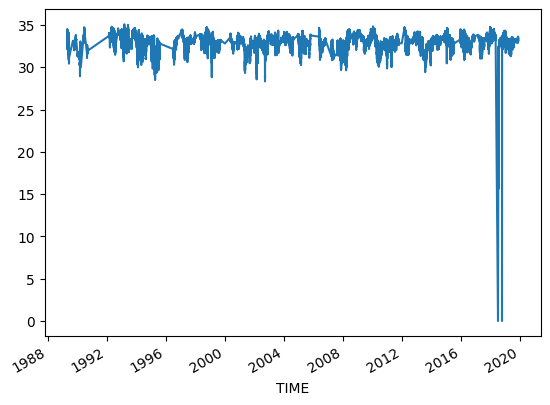

In [4]:
german_bright_6.salt_6.plot()

In [5]:
german_bright_6 = german_bright_6.loc[german_bright_6.salt_6 > 25]

In [6]:
german_bright_6.index.weekday.unique()

Int64Index([2, 3, 4, 5, 6, 0, 1], dtype='int64', name='TIME')

In [7]:
missing = pd.date_range(start = '1992-01-01', end = '2022-12-31').difference(german_bright_6.index.date).to_series()

missing_months = missing.groupby([missing.index.year,missing.index.month]).count()
missing_years = missing.groupby([missing.index.year]).count()

<Axes: >

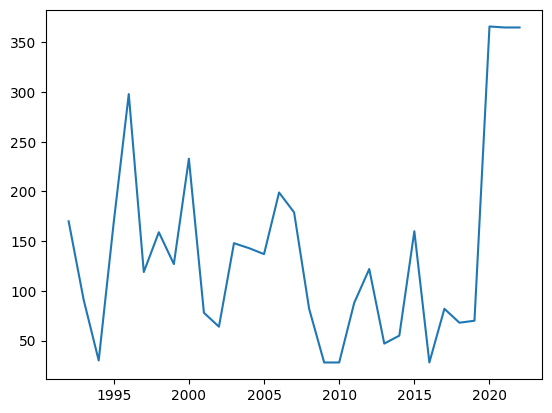

In [8]:
missing_years.plot()

<Axes: >

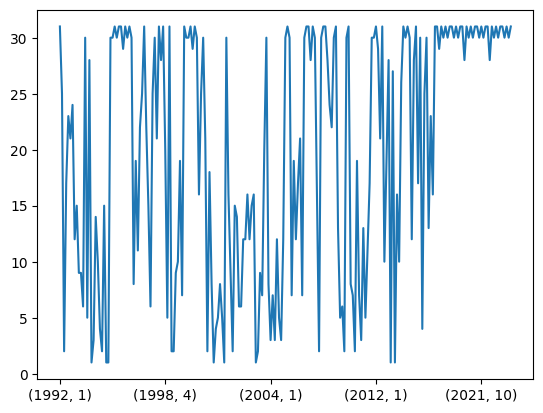

In [9]:
missing_months.plot()

<Axes: >

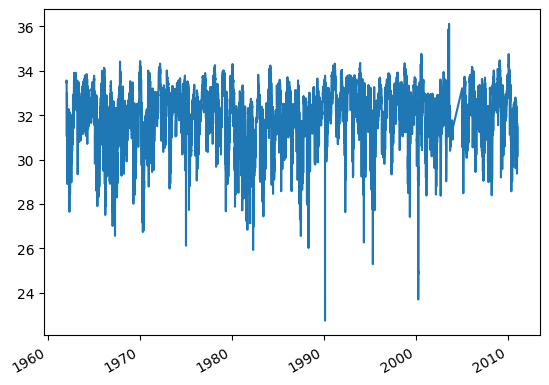

In [10]:
real = pd.read_csv("../data/trainings_df.csv")
real.index = pd.to_datetime(real.Datum,dayfirst=True)
real.index = pd.to_datetime(real.index.astype(str) + " " + real.Uhrzeit)
real = real.loc[real.Salinität.notna()]
real.Salinität.plot()

In [11]:
cut_off = 1
meaned = german_bright_6.salt_6

gathered_means = []
for real_i in real.index.values:
    
    differences = np.abs(meaned.index - real_i).values  / np.timedelta64(1, 'D')
    
    mask = differences < cut_off
    
    if mask.sum() == 0:
        gathered_means.append(np.nan)
        continue
        
    gathered_means.append(meaned.loc[mask].mean())    
    
gathered_means = np.array(gathered_means)
np.isnan(gathered_means).mean()

0.7306695271297041

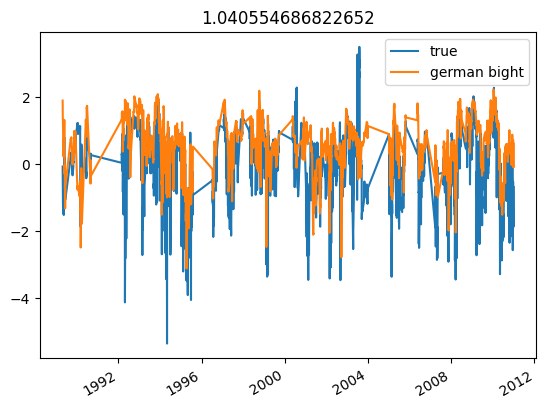

In [12]:
from sklearn.metrics import mean_squared_error
masked_real = real["Salinität"].to_frame().copy()
masked_real['gathered'] = gathered_means
masked_real = masked_real.loc[masked_real.gathered.notna()]
def norm(sal):
    
    return (sal - 32.21740044) / 1.11161782

masked_real['true'] = masked_real.Salinität.apply(norm)
masked_real['gat'] = masked_real.gathered.apply(norm)

masked_real['true'].plot(label= 'true')
masked_real['gat'].plot(label="german bight")
plt.legend()
rmse = mean_squared_error(masked_real['true'],masked_real['gat'],squared=False)
plt.title(rmse)
plt.show()

In [13]:
val_x = masked_real.gat.iloc[int(len(masked_real)*0.8):]
val_y = masked_real.true.iloc[int(len(masked_real)*0.8):]


train_x = masked_real.gat.iloc[:int(len(masked_real)*0.8)]
train_y = masked_real.true.iloc[:int(len(masked_real)*0.8)]


In [14]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(np.expand_dims(train_x,1),train_y)

preds = model.predict(np.expand_dims(val_x,1))
mean_squared_error(val_y,preds,squared=False)

0.7268425741833705

In [15]:
times = pd.read_csv('../data/times.csv',index_col=2,parse_dates=True)
times

,datum,time_as_number
time,,
1962-01-02 09:00:00,02.01.1962,9.000000
1962-01-03 09:00:00,03.01.1962,9.000000
1962-01-04 09:00:00,04.01.1962,9.000000
1962-01-05 09:00:00,05.01.1962,9.000000
1962-01-08 09:00:00,08.01.1962,9.000000
...,...,...
2013-12-18 07:52:00,18.12.2013,7.866667
2013-12-19 09:09:00,19.12.2013,9.150000
2013-12-20 08:00:00,20.12.2013,8.000000


In [16]:
number_of_neighbors = []
def get_salt_mea(real_i):
    
    differences = np.abs(meaned.index - real_i).values  / np.timedelta64(1, 'D')
    
    mask = differences < cut_off
    
    number_of_neighbors.append(mask.sum())    
    if mask.sum() == 0:
        return (np.nan)
        
    
    return norm(meaned.loc[mask].mean())    


def get_closest(real_i):
    
    differences = np.abs(meaned.index - real_i).values  / np.timedelta64(1, 'D')
    
    mask = differences < cut_off
    
    number_of_neighbors.append(mask.sum())    
    if mask.sum() == 0:
        return (np.nan)
        
    
    fitting = meaned.loc[mask]
    closest_args = np.argsort(np.abs(real_i- fitting.index).values)[:5]
    
    return norm(fitting.iloc[closest_args].values.mean())    




times["all_salt"] = times.index.to_series().apply(get_salt_mea)
times["closest_salt"]= times.index.to_series().apply(get_closest)

<Axes: xlabel='time'>

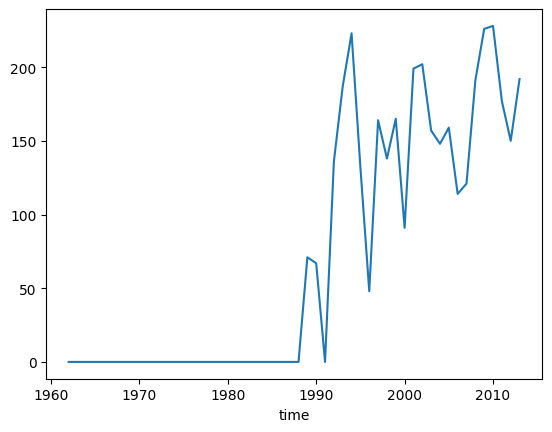

In [17]:
times.groupby(times.index.year).all_salt.count().plot()

In [18]:
times.loc[times.index.year > 1999].all_salt.isna().mean()

0.29638482222886164

<Axes: ylabel='Count'>

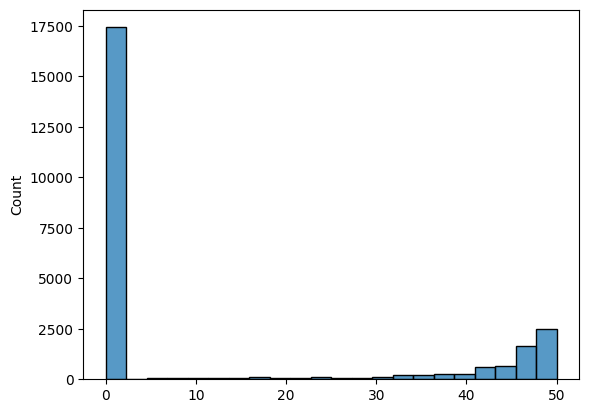

In [19]:
sns.histplot(number_of_neighbors)

In [20]:
submission_ds = pd.read_csv('../data/bbdc_student/bbdc_2023_AWI_data_evaluate_skeleton_student.csv', delimiter=';',skiprows=[1],index_col=0)
submission_ds['datum'] =submission_ds.index
submission_ds.index = pd.to_datetime(submission_ds.index + " " + submission_ds.Uhrzeit,format='%d.%m.%Y %H:%M')
submission_ds["time"] = submission_ds.index
submission_ds["salt_means_isec"] = submission_ds.time.apply(get_salt_mea)

In [21]:
submission_ds["salt_means_isec"].notna().mean()

0.7297592997811816

<Axes: xlabel='time'>

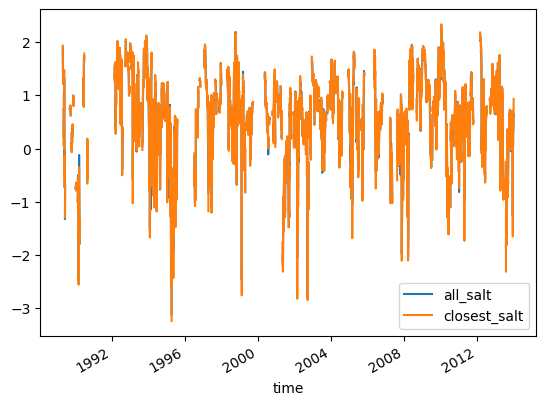

In [22]:
times.iloc[:,-2:].plot()

<Axes: >

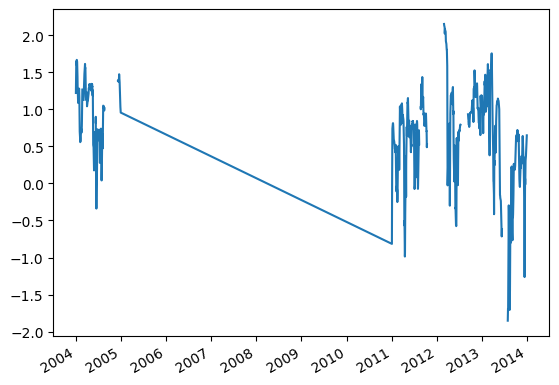

In [23]:
submission_ds["salt_means_isec"].plot()

In [24]:
times.to_csv("salts.csv")

In [25]:
times = pd.read_csv('../data/prof_times.csv',index_col=2,parse_dates=True)
times
number_of_neighbors = []
def get_salt_mea(real_i):
    
    differences = np.abs(meaned.index - real_i).values  / np.timedelta64(1, 'D')
    
    mask = differences < cut_off
    
    number_of_neighbors.append(mask.sum())    
    if mask.sum() == 0:
        return (np.nan)
        
    
    return norm(meaned.loc[mask].mean())    


def get_closest(real_i):
    
    differences = np.abs(meaned.index - real_i).values  / np.timedelta64(1, 'D')
    
    mask = differences < cut_off
    
    number_of_neighbors.append(mask.sum())    
    if mask.sum() == 0:
        return (np.nan)
        
    
    fitting = meaned.loc[mask]
    closest_args = np.argsort(np.abs(real_i- fitting.index).values)[:5]
    
    return norm(fitting.iloc[closest_args].values.mean())    




times["all_salt"] = times.index.to_series().apply(get_salt_mea)
times["closest_salt"]= times.index.to_series().apply(get_closest)


<Axes: xlabel='time'>

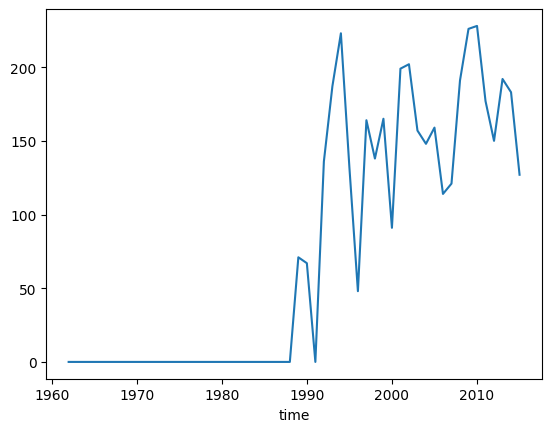

In [26]:

times.groupby(times.index.year).all_salt.count().plot()

In [27]:
times.to_csv("prof_salts.csv")


In [30]:
times

,datum,time_as_number,all_salt,closest_salt
time,,,,
1962-01-02 09:00:00,02.01.1962,9.000000,NaN,NaN
1962-01-03 09:00:00,03.01.1962,9.000000,NaN,NaN
1962-01-04 09:00:00,04.01.1962,9.000000,NaN,NaN
1962-01-05 09:00:00,05.01.1962,9.000000,NaN,NaN
1962-01-08 09:00:00,08.01.1962,9.000000,NaN,NaN
...,...,...,...,...
2015-12-22 08:20:00,22.12.2015,8.333333,1.333358,1.126827
2015-12-23 08:01:00,23.12.2015,8.016667,1.083534,1.002684
2015-12-28 07:50:00,28.12.2015,7.833333,1.084719,1.125028


In [31]:
old = pd.read_csv("../../BBDC_2023/bsh_daten/prof_salts.csv",index_col=0,parse_dates=True)
old

,datum,time_as_number,all_salt,closest_salt
time,,,,
1962-01-02 09:00:00,02.01.1962,9.000000,NaN,NaN
1962-01-03 09:00:00,03.01.1962,9.000000,NaN,NaN
1962-01-04 09:00:00,04.01.1962,9.000000,NaN,NaN
1962-01-05 09:00:00,05.01.1962,9.000000,NaN,NaN
1962-01-08 09:00:00,08.01.1962,9.000000,NaN,NaN
...,...,...,...,...
2015-12-22 08:20:00,22.12.2015,8.333333,1.333357,1.126826
2015-12-23 08:01:00,23.12.2015,8.016667,1.083533,1.002682
2015-12-28 07:50:00,28.12.2015,7.833333,1.084717,1.125027


In [36]:
(old.iloc[:,1:]-times.iloc[:,1:]).describe()

,time_as_number,all_salt,closest_salt
count,12822.0,3996.000000,3996.000000
mean,0.0,0.000017,0.000104
std,0.0,0.000327,0.005220
min,0.0,-0.007220,-0.053977
25%,0.0,-0.000001,-0.000001
50%,0.0,-0.000001,-0.000001
75%,0.0,-0.000001,-0.000001
max,0.0,0.014777,0.264478
